In [1]:
import diffusers
diffusers.__version__

'0.8.0.dev0'

In [1]:
from pathlib import Path

import torch

from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline


def patch_pipe(pipe):
    def null_safety_checker(images, *args, **kwargs):
        return images, None

    def null_feature_extractor(images, return_tensors="pt", **kwargs):
        class Dummy:
            def __init__(self):
                self.pixel_values = torch.zeros((1,))

            def to(self, *args, **kwargs):
                return self

        return Dummy()

    scheduler = DPMSolverMultistepScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
        trained_betas=None,
        predict_epsilon=True,
        thresholding=False,
        algorithm_type="dpmsolver++",
        solver_type="midpoint",
        lower_order_final=True,
    )

    pipe.safety_checker = null_safety_checker
    pipe.feature_extractor = null_feature_extractor
    pipe.scheduler = scheduler
    pipe.enable_xformers_memory_efficient_attention()
    if not hasattr(pipe, "prefix"):
        pipe.prefix = ""
    return pipe


StableDiffusionPipeline.patch_pipe = patch_pipe

# model_id = 'CompVis/stable-diffusion-v1-4'
model_id = Path.home() / "models" / "stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
).patch_pipe()

In [2]:
model_id = "DGSpitzer/Cyberpunk-Anime-Diffusion"
model_id = Path.home() / "models" / "Cyberpunk-Anime-Diffusion"
pipe2 = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
).patch_pipe()
pipe2.prefix = "dgs illustration style "

In [3]:
model_id = "dallinmackay/Van-Gogh-diffusion"
model_id, prefix = Path.home() / "models" / "Van-Gogh-diffusion", "lvngvncnt "
pipe3 = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
).patch_pipe()
pipe3.prefix = prefix

In [4]:
def test(pipe, prompt="astronaut riding a horse on mars", seed=42, steps=25):
    device = pipe.device  # get the current device
    # only move to cuda when inferencing, to avoid OOM when loading multiple models on cuda
    pipe = pipe.to("cuda")
    if hasattr(pipe, "prefix"):
        prompt = pipe.prefix + prompt
    print(f"{prompt=}")
    rng_generator = torch.Generator("cuda").manual_seed(seed)
    image = pipe(
        prompt,
        negative_prompt="low quality, bad image",
        num_inference_steps=steps,
        generator=rng_generator,
    ).images[0]

    pipe = pipe.to(device)  # put back on original device
    return image

prompt='dgs illustration style astronaut riding a horse on mars'


  0%|          | 0/25 [00:00<?, ?it/s]

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

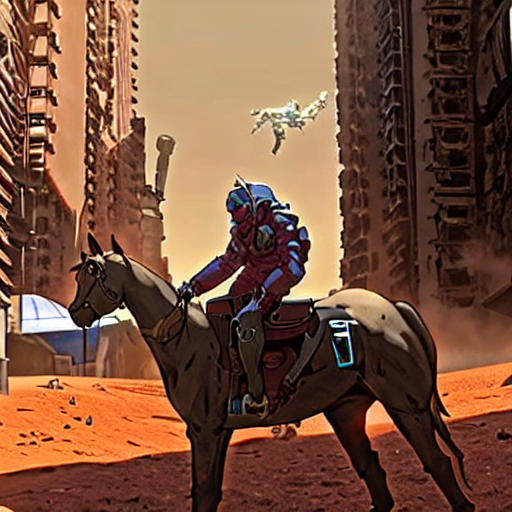

In [5]:
test(pipe2)

prompt='lvngvncnt astronaut riding a horse on mars'


  0%|          | 0/25 [00:00<?, ?it/s]

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

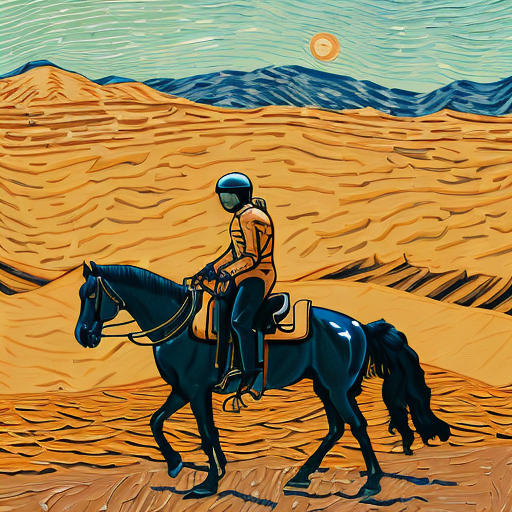

In [6]:
test(pipe3)

In [7]:
def merge_weights(state_dict_1, state_dict_2, weight1=1, weight2=1):
    return {
        k: (state_dict_1[k] * weight1 + state_dict_2[k] * weight2) / (weight1 + weight2)
        for k in state_dict_1.keys()
    }


def get_merged_model(pipe1, pipe2, weight1=1, weight2=1):
    # model_id = 'CompVis/stable-diffusion-v1-4'
    model_id = Path.home() / "models" / "stable-diffusion-v1-4"
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipe.unet.load_state_dict(
        merge_weights(
            pipe1.unet.state_dict(), pipe2.unet.state_dict(), weight1, weight2
        )
    )
    pipe.text_encoder.load_state_dict(
        merge_weights(
            pipe1.text_encoder.state_dict(),
            pipe2.text_encoder.state_dict(),
            weight1,
            weight2,
        )
    )
    pipe.prefix = pipe1.prefix + pipe2.prefix
    return pipe

In [8]:
pipe23 = get_merged_model(pipe2, pipe3)

prompt='dgs illustration style lvngvncnt astronaut riding a horse on mars'


  0%|          | 0/26 [00:00<?, ?it/s]

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

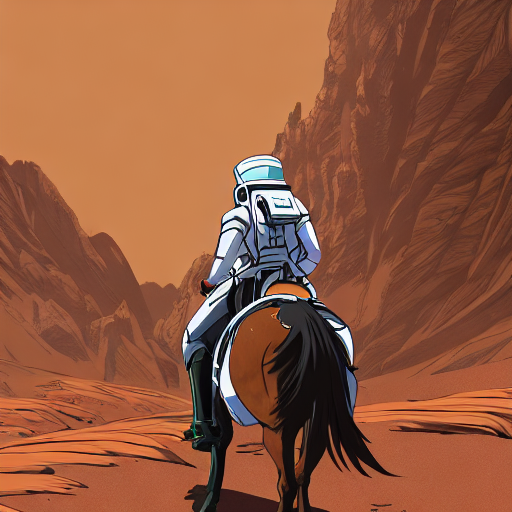

In [9]:
test(pipe23)

prompt='lvngvncnt dgs illustration style astronaut riding a horse on mars'


  0%|          | 0/26 [00:00<?, ?it/s]

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

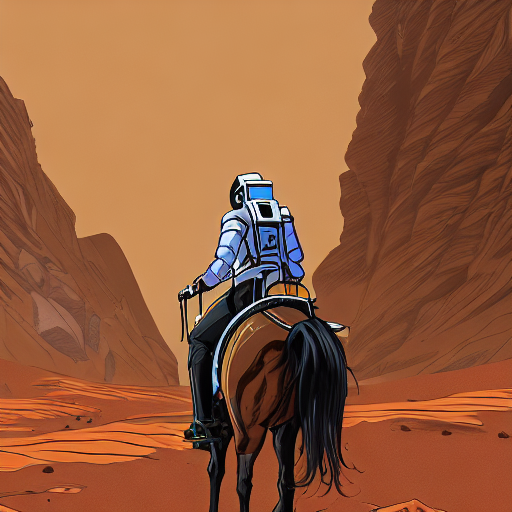

In [10]:
# more van gogh

# adjust interpolation weights
pipe23 = get_merged_model(pipe2, pipe3, weight1=1, weight2=1)
# or adjust the prefix
pipe23.prefix = pipe3.prefix + pipe2.prefix
test(pipe23)

prompt='dgs illustration style lvngvncnt astronaut riding a horse on mars'


  0%|          | 0/26 [00:00<?, ?it/s]

Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `torch_dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipelin

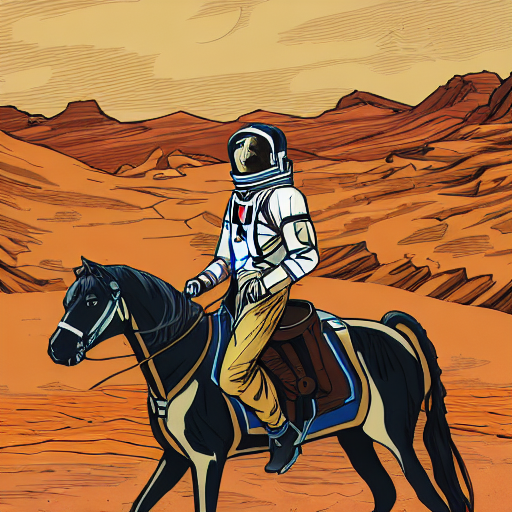

In [11]:
# even higher interpolation weight
pipe23 = get_merged_model(pipe2, pipe3, weight1=1, weight2=3)
test(pipe23)